Iteration 2000: ar mg gifrkes ory mise vfnresobne geosl mg dothes kove me li
Iteration 4000: or my yiurgen ard mine vulrenable yeans my fathen gave me si
Iteration 6000: in my younger and more vulnerable years my father gave me so
Iteration 8000: in my younger and more vulnerable years my father gave me so
Iteration 10000: in my younger and more vulnerable years my father gave me so
Iteration 12000: in my younger and more vulnerable years my father gave me so
Iteration 14000: in my younger and more vulnerable years my father gave me so
Iteration 16000: in my younger and more vulnerable years my father gave me so
Iteration 18000: in my younger and more vulnerable years my father gave me so
Iteration 20000: in my younger and more vulnerable years my father gave me so

Final Acceptance Rate: 0.17

Decrypted Message:
in my younger and more vulnerable years my father gave me some advice that ixve been turning over in my mind ever since. *whenever you feel like criticizing any one,* he told 

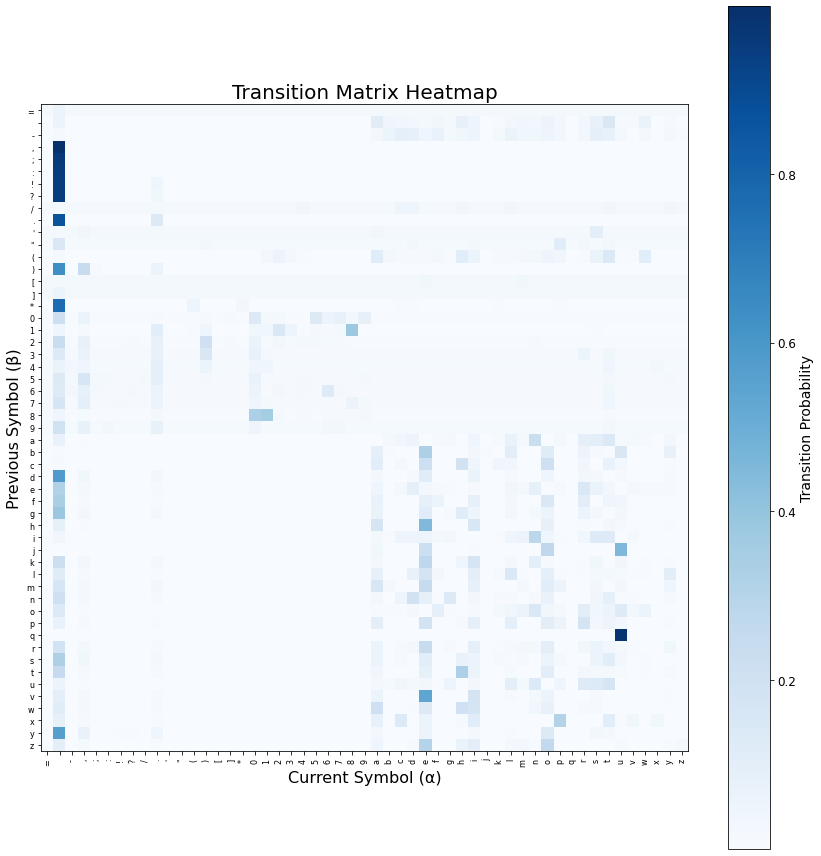

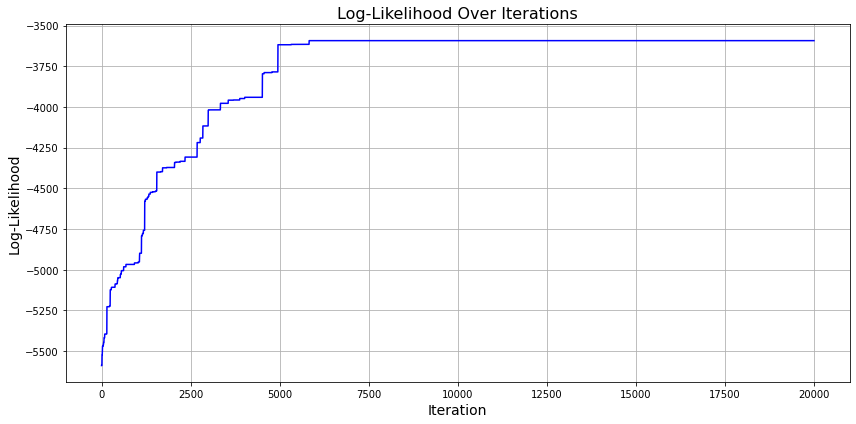

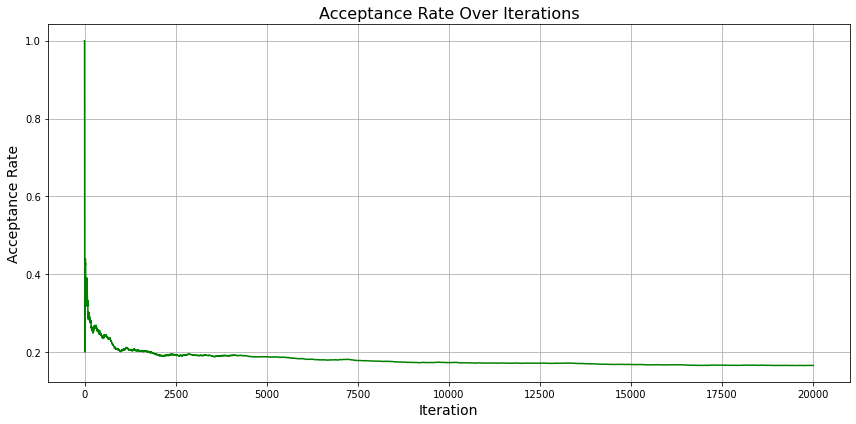

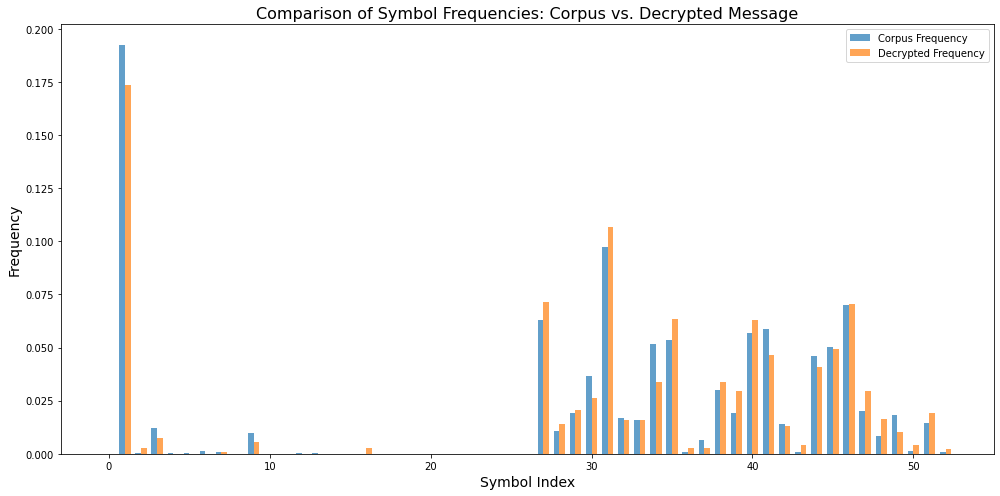

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def load_symbols(symbols_file):
    """
    Load symbols from a file, replacing empty lines with a space character.

    Args:
        symbols_file (str): Path to the symbols file.

    Returns:
        list: A list of symbols.
    """
    with open(symbols_file, 'r') as f:
        symbols = [line.rstrip('\n') for line in f]
    # Replace empty strings with space character to represent '⟨space⟩'
    symbols = [symbol if symbol else ' ' for symbol in symbols]
    return symbols


# Load the list of symbols from 'symbols.txt'
symbols = load_symbols('symbols.txt')

# Create dictionaries to map symbols to indices and vice versa
symbol_to_index = {symbol: idx for idx, symbol in enumerate(symbols)}
index_to_symbol = {idx: symbol for idx, symbol in enumerate(symbols)}
N_symbols = len(symbols)  # Total number of unique symbols

# Verify that the space character is present in the symbol mappings
if ' ' not in symbol_to_index:
    raise ValueError("Space character ' ' is not present in symbols.txt.")

# Load the encrypted message from 'message.txt'
with open('message.txt', 'r') as f:
    encrypted_message = f.read().strip()

# Identify all unique symbols present in the encrypted message
unique_encrypted_symbols = set(encrypted_message)

# Check for any symbols in the encrypted message that are not in 'symbols.txt'
missing_symbols = unique_encrypted_symbols - set(symbols)
if missing_symbols:
    raise ValueError(f"Missing symbols in symbols.txt: {missing_symbols}")

# Convert the encrypted message symbols to their corresponding indices
encrypted_indices = np.array([symbol_to_index[s] for s in encrypted_message])


def load_corpus(corpus_file):
    """
    Load and preprocess the corpus text by retaining only allowed symbols.

    Args:
        corpus_file (str): Path to the corpus file.

    Returns:
        str: Preprocessed corpus text.
    """
    with open(corpus_file, 'r', encoding='utf-8') as f:
        text = f.read().lower()  # Convert text to lowercase for consistency
    allowed_chars = set(symbols)  # Define allowed characters based on symbols
    # Replace any character not in allowed_chars with a space
    text = ''.join([char if char in allowed_chars else ' ' for char in text])
    return text


# Load and preprocess the corpus
corpus = load_corpus('war_and_peace.txt')

# Initialize an array to count unigram (single symbol) occurrences in the corpus
unigram_counts = np.zeros(N_symbols, dtype=int)
for char in corpus:
    idx = symbol_to_index[char]  # Get the index of the current character
    unigram_counts[idx] += 1      # Increment the count for this symbol

# Initialize a 2D array to count bigram (pair of symbols) occurrences in the corpus
bigram_counts = np.zeros((N_symbols, N_symbols), dtype=int)
for i in range(len(corpus) - 1):
    idx1 = symbol_to_index[corpus[i]]       # Index of the first symbol in the bigram
    idx2 = symbol_to_index[corpus[i + 1]]   # Index of the second symbol in the bigram
    bigram_counts[idx1, idx2] += 1           # Increment the count for this bigram

# Apply Laplace (add-one) smoothing to unigram and bigram counts to avoid zero probabilities
unigram_counts += 1
bigram_counts += 1

# Compute unigram probabilities (stationary distribution) by normalizing unigram counts
phi = unigram_counts / np.sum(unigram_counts)

# Compute bigram probabilities (transition probabilities) by normalizing bigram counts
bigram_totals = bigram_counts.sum(axis=1, keepdims=True)  # Sum of bigrams starting with each symbol
psi = bigram_counts / bigram_totals

# Initialize an array to count unigram occurrences in the encrypted message
encrypted_unigram_counts = np.zeros(N_symbols, dtype=int)
for idx in encrypted_indices:
    encrypted_unigram_counts[idx] += 1  # Increment count for each symbol in the encrypted message

# Initialize a 2D array to count bigram occurrences in the encrypted message
encrypted_bigram_counts = np.zeros((N_symbols, N_symbols), dtype=int)
for i in range(len(encrypted_indices) - 1):
    idx1 = encrypted_indices[i]       # Index of the first symbol in the bigram
    idx2 = encrypted_indices[i + 1]   # Index of the second symbol in the bigram
    encrypted_bigram_counts[idx1, idx2] += 1  # Increment the count for this bigram


# Intelligent Initialization
# Step 1: Initial mapping based on unigram frequencies
# Sort plaintext symbols by descending unigram counts (most frequent first)
plaintext_indices_sorted = np.argsort(-unigram_counts)
# Sort ciphertext symbols by descending unigram counts in the encrypted message
ciphertext_indices_sorted = np.argsort(-encrypted_unigram_counts)

# Initialize the permutation array where index corresponds to ciphertext symbol
# and value corresponds to plaintext symbol
initial_permutation = np.zeros(N_symbols, dtype=int)
initial_permutation[ciphertext_indices_sorted] = plaintext_indices_sorted


def refine_permutation(permutation, plaintext_bigram_freq, ciphertext_bigram_freq, iterations=5):
    """
    Refine the initial permutation by swapping symbol mappings to better align bigram frequencies.

    Args:
        permutation (np.ndarray): Current permutation array mapping ciphertext to plaintext indices.
        plaintext_bigram_freq (np.ndarray): Normalized bigram frequencies from the corpus.
        ciphertext_bigram_freq (np.ndarray): Normalized bigram frequencies from the encrypted message.
        iterations (int): Number of refinement iterations to perform.

    Returns:
        np.ndarray: Refined permutation array.
    """
    for _ in range(iterations):
        # Iterate over each ciphertext symbol
        for cipher_idx in range(N_symbols):
            # Get the current plaintext symbol mapped to this ciphertext symbol
            plain_idx = permutation[cipher_idx]
            # Compute the current score based on the absolute difference in bigram frequencies
            current_score = np.sum(
                np.abs(ciphertext_bigram_freq[cipher_idx] - plaintext_bigram_freq[plain_idx])
            )
            # Try swapping with other ciphertext symbols to find a better mapping
            for other_cipher_idx in range(N_symbols):
                if other_cipher_idx == cipher_idx:
                    continue  # Skip swapping with itself
                other_plain_idx = permutation[other_cipher_idx]
                # Swap the plaintext mappings
                permutation[cipher_idx], permutation[other_cipher_idx] = other_plain_idx, plain_idx
                # Compute the new score after swapping
                new_score = (
                    np.sum(
                        np.abs(ciphertext_bigram_freq[cipher_idx] - plaintext_bigram_freq[other_plain_idx])
                    )
                    + np.sum(
                        np.abs(ciphertext_bigram_freq[other_cipher_idx] - plaintext_bigram_freq[plain_idx])
                    )
                )
                # If the new score is better (lower), keep the swap
                if new_score < current_score:
                    current_score = new_score
                    plain_idx = other_plain_idx
                else:
                    # Revert the swap if it does not improve the score
                    permutation[cipher_idx], permutation[other_cipher_idx] = plain_idx, other_plain_idx
    return permutation


# Normalize bigram counts to frequencies for comparison
plaintext_bigram_freq = bigram_counts / bigram_counts.sum()
ciphertext_bigram_freq = encrypted_bigram_counts / encrypted_bigram_counts.sum()

# Refine the initial permutation to better align bigram frequencies
current_permutation = initial_permutation.copy()
current_permutation = refine_permutation(
    current_permutation, plaintext_bigram_freq, ciphertext_bigram_freq, iterations=3
)


def compute_log_likelihood(permutation, encrypted_indices):
    """
    Compute the log-likelihood of the decrypted message based on the current permutation.

    Args:
        permutation (np.ndarray): Current permutation array mapping ciphertext to plaintext indices.
        encrypted_indices (np.ndarray): Array of indices representing the encrypted message.

    Returns:
        float: Log-likelihood value.
    """
    decrypted_indices = permutation[encrypted_indices]  # Decrypt the message using the permutation
    first_idx = decrypted_indices[0]                    # Index of the first decrypted symbol
    log_likelihood = np.log(phi[first_idx])            # Add log probability of the first symbol
    prev_indices = decrypted_indices[:-1]               # All symbols except the last
    curr_indices = decrypted_indices[1:]                # All symbols except the first
    psi_values = psi[prev_indices, curr_indices]        # Transition probabilities for each bigram
    psi_values = np.clip(psi_values, a_min=1e-12, a_max=None)  # Avoid log(0) by clipping
    log_likelihood += np.sum(np.log(psi_values))       # Add log probabilities of transitions
    return log_likelihood


# Metropolis-Hastings sampler parameters
num_iterations = 20000    # Total number of MH iterations
print_interval = 2000     # Interval at which to print decrypted text

# Initialize variables to track the best permutation and its log-likelihood
best_permutation = current_permutation.copy()
best_log_likelihood = compute_log_likelihood(current_permutation, encrypted_indices)

# Lists to store log-likelihoods and acceptance rates for plotting
log_likelihood_history = []
acceptance_history = []

# Counter for accepted proposals to calculate acceptance rate
accepted = 0

# Run the Metropolis-Hastings sampler
for iteration in range(1, num_iterations + 1):
    # Propose a new permutation by swapping two randomly selected symbols
    swap_indices = np.random.choice(N_symbols, 2, replace=False)
    proposal_permutation = current_permutation.copy()
    i, j = swap_indices
    proposal_permutation[i], proposal_permutation[j] = proposal_permutation[j], proposal_permutation[i]

    # Compute log-likelihoods for the current and proposed permutations
    current_ll = compute_log_likelihood(current_permutation, encrypted_indices)
    proposal_ll = compute_log_likelihood(proposal_permutation, encrypted_indices)

    # Calculate the difference in log-likelihoods
    delta_ll = proposal_ll - current_ll

    # Compute the acceptance probability using the Metropolis criterion
    acceptance_prob = min(1, np.exp(delta_ll))

    # Decide whether to accept the proposed permutation
    if np.random.rand() < acceptance_prob:
        current_permutation = proposal_permutation  # Accept the proposal
        current_ll = proposal_ll
        accepted += 1  # Increment the acceptance counter

        # Update the best permutation found if the new one has a higher log-likelihood
        if current_ll > best_log_likelihood:
            best_permutation = current_permutation.copy()
            best_log_likelihood = current_ll

    # Record log-likelihood and acceptance status for plotting
    log_likelihood_history.append(best_log_likelihood)
    acceptance_history.append(accepted / iteration)  # Running acceptance rate

    # Print the decrypted text of the first 60 symbols at specified intervals
    if iteration % print_interval == 0:
        decrypted_indices = current_permutation[encrypted_indices[:60]]  # Decrypt first 60 symbols
        decrypted_text = ''.join([index_to_symbol[idx] for idx in decrypted_indices])
        print(f"Iteration {iteration}: {decrypted_text}")

# After sampling, compute the final acceptance rate
final_acceptance_rate = accepted / num_iterations
print(f"\nFinal Acceptance Rate: {final_acceptance_rate:.2f}")

# Output the final decrypted message using the best permutation found
full_decrypted_indices = best_permutation[encrypted_indices]
full_decrypted_text = ''.join([index_to_symbol[idx] for idx in full_decrypted_indices])

print("\nDecrypted Message:")
print(full_decrypted_text)


# Plotting the Transition Matrix Heatmap
plt.figure(figsize=(12, 12))
plt.imshow(psi, cmap='Blues', interpolation='nearest')
plt.title('Transition Matrix Heatmap', fontsize=20)
plt.xlabel('Current Symbol (α)', fontsize=16)
plt.ylabel('Previous Symbol (β)', fontsize=16)

# Set ticks to symbols with rotation for better readability
plt.xticks(ticks=np.arange(N_symbols), labels=symbols, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(N_symbols), labels=symbols, fontsize=8)

# Add colorbar with label
cbar = plt.colorbar()
cbar.set_label('Transition Probability', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('transition_matrix_heatmap.png', dpi=300)
plt.show()



# Plotting the Log-Likelihood Over Iterations
plt.figure(figsize=(12, 6))
plt.plot(log_likelihood_history, color='blue')
plt.title('Log-Likelihood Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log-Likelihood', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('log_likelihood_over_iterations.png', dpi=300)
plt.show()


# Plotting the Acceptance Rate Over Iterations
plt.figure(figsize=(12, 6))
plt.plot(acceptance_history, color='green')
plt.title('Acceptance Rate Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Acceptance Rate', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('acceptance_rate_over_iterations.png', dpi=300)
plt.show()


# Plotting Symbol Frequency Comparison
# Compute decrypted unigram counts
decrypted_unigram_counts = np.zeros(N_symbols, dtype=int)
for idx in full_decrypted_indices:
    decrypted_unigram_counts[idx] += 1

# Normalize counts to get frequencies
decrypted_freq = decrypted_unigram_counts / decrypted_unigram_counts.sum()
corpus_freq = unigram_counts / unigram_counts.sum()

# Plotting comparison of frequencies
plt.figure(figsize=(14, 7))
indices = np.arange(N_symbols)
width = 0.35  # Width of the bars

plt.bar(indices - width/2, corpus_freq, width, label='Corpus Frequency', alpha=0.7)
plt.bar(indices + width/2, decrypted_freq, width, label='Decrypted Frequency', alpha=0.7)

plt.xlabel('Symbol Index', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Comparison of Symbol Frequencies: Corpus vs. Decrypted Message', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig('symbol_frequency_comparison.png', dpi=300)
plt.show()


Iteration 100: tr uw wlhryes orm ulse fhdresobde weosi uw koanes yofe ue il
Iteration 200: tr uw wlhrmes ory ulse fhdresobde weosi uw koanes mofe ue il
Iteration 400: tr ud dlhrmes ory ulse phwresobwe deosi ud koanes mope ue il
Iteration 600: tr pd dahrues ory pase mhwresobwe deosl pd koines uome pe la
Iteration 700: lr py yahrues ord pase vhwresobwe yeost py koines uove pe ta
Iteration 800: lr cy yahrues ord case vhpresobpe yeost cy koines uove ce ta
Iteration 900: lr cy yahruen ord cane vhprenobpe yeont cy koisen uove ce ta
Iteration 1000: lr cy yahruen ord cane vhprenobpe yeont cy koisen uove ce ta
Iteration 1100: lr cy yahruen ord cane vhprenobpe yeont cy koisen uove ce ta
Iteration 1200: ir cy yahruen ord cane vhprenobpe yeont cy kolsen uove ce ta
Iteration 1300: ir cy yahruen ord cane vhprenobpe yeont cy kolwen uove ce ta
Iteration 1400: ir cy yahruen ord cane vhprenobpe yeont cy kolwen uove ce ta
Iteration 1500: ir cy yahruen ord cane vhprenobpe yeont cy kolwen uove ce ta
Iterat

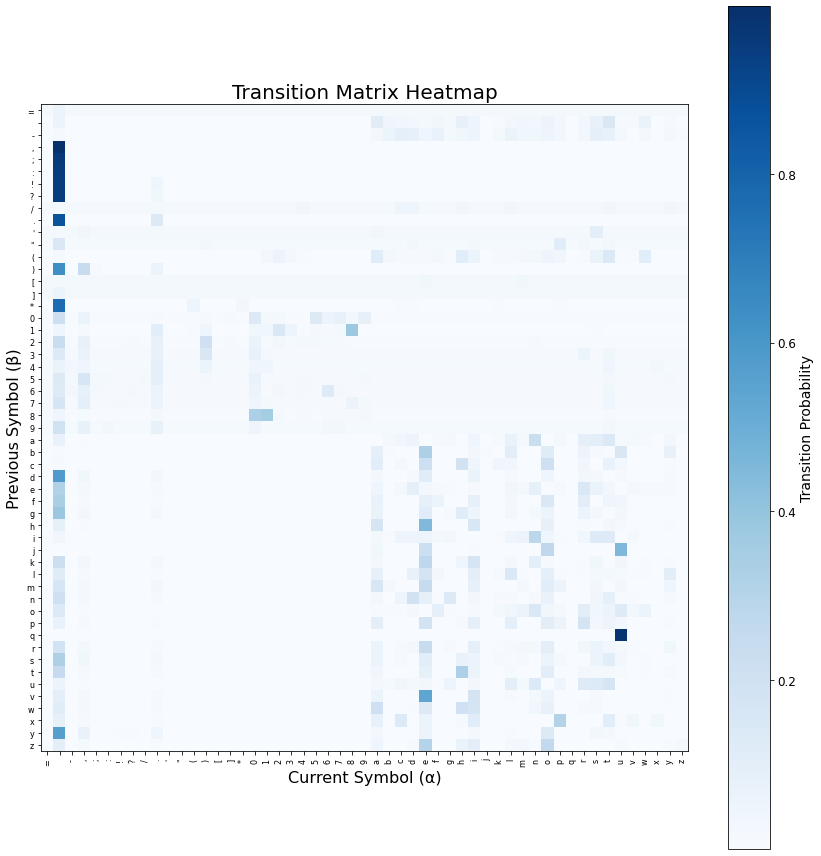

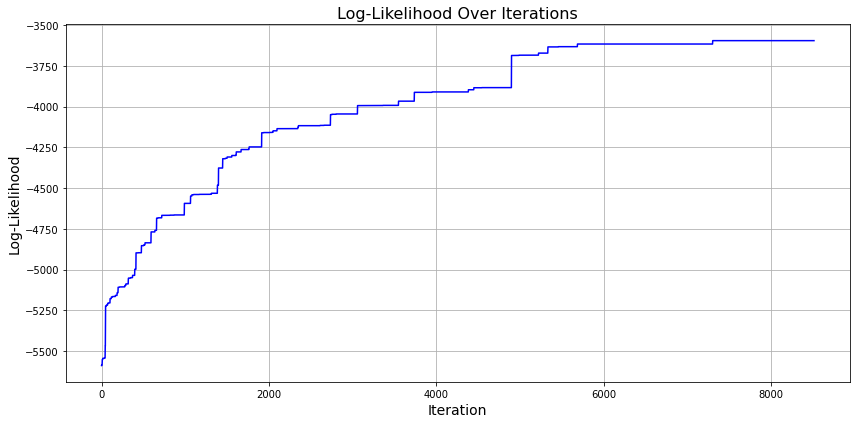

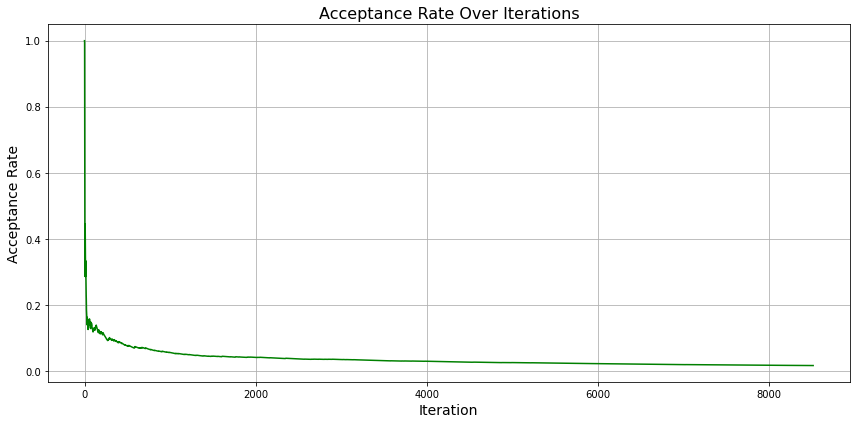

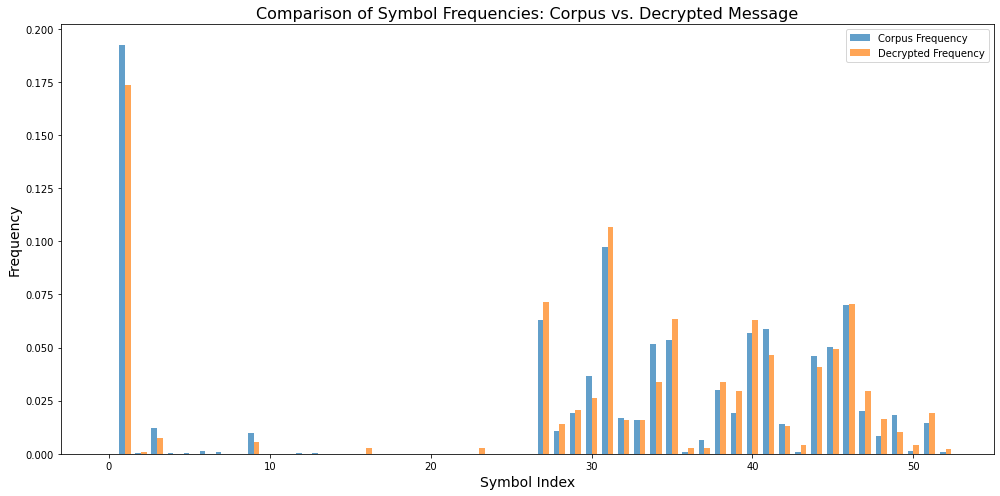

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def load_symbols(symbols_file):
    """
    Load symbols from a file, replacing empty lines with a space character.

    Args:
        symbols_file (str): Path to the symbols file.

    Returns:
        list: A list of symbols.
    """
    with open(symbols_file, 'r') as f:
        symbols = [line.rstrip('\n') for line in f]
    # Replace empty strings with space character to represent '⟨space⟩'
    symbols = [symbol if symbol else ' ' for symbol in symbols]
    return symbols


# Load the list of symbols from 'symbols.txt'
symbols = load_symbols('symbols.txt')

# Create dictionaries to map symbols to indices and vice versa
symbol_to_index = {symbol: idx for idx, symbol in enumerate(symbols)}
index_to_symbol = {idx: symbol for idx, symbol in enumerate(symbols)}
N_symbols = len(symbols)  # Total number of unique symbols

# FOR DEBUGGING: Verify that the space character is present in the symbol mappings
if ' ' not in symbol_to_index:
    raise ValueError("Space character ' ' is not present in symbols.txt.")

# Load the encrypted message from 'message.txt'
with open('message.txt', 'r') as f:
    encrypted_message = f.read().strip()

# FOR DEBUGGING: Identify all unique symbols present in the encrypted message
unique_encrypted_symbols = set(encrypted_message)

# FOR DEBUGGING: Check for any symbols in the encrypted message that are not in 'symbols.txt'
missing_symbols = unique_encrypted_symbols - set(symbols)
if missing_symbols:
    raise ValueError(f"Missing symbols in symbols.txt: {missing_symbols}")

# FOR DEBUGGING: Convert the encrypted message symbols to their corresponding indices
encrypted_indices = np.array([symbol_to_index[s] for s in encrypted_message], dtype=np.int32)


def load_corpus(corpus_file):
    """
    Load and preprocess the corpus text by retaining only allowed symbols.

    Args:
        corpus_file (str): Path to the corpus file.

    Returns:
        np.ndarray: Array of symbol indices representing the corpus.
    """
    with open(corpus_file, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    allowed_chars = set(symbols)
    # Replace any character not in allowed_chars with a space
    text = ''.join([char if char in allowed_chars else ' ' for char in text])
    # Convert text to indices
    text_indices = np.array([symbol_to_index[char] for char in text], dtype=np.int32)
    return text_indices


# Load and preprocess the corpus
corpus_indices = load_corpus('war_and_peace.txt')

# Vectorized unigram counts
unigram_counts = np.bincount(corpus_indices, minlength=N_symbols)

# Vectorized bigram counts
indices1 = corpus_indices[:-1]
indices2 = corpus_indices[1:]
bigram_counts = np.zeros((N_symbols, N_symbols), dtype=np.int32)
np.add.at(bigram_counts, (indices1, indices2), 1)

# Apply Laplace (add-one) smoothing to unigram and bigram counts to avoid zero probabilities
unigram_counts += 1
bigram_counts += 1

# Compute unigram probabilities (stationary distribution) by normalizing unigram counts
phi = unigram_counts / np.sum(unigram_counts)

# Compute bigram probabilities (transition probabilities) by normalizing bigram counts
bigram_totals = bigram_counts.sum(axis=1, keepdims=True)  # Sum of bigrams starting with each symbol
psi = bigram_counts / bigram_totals

# Precompute logarithms
log_phi = np.log(phi)
log_psi = np.log(psi)

# Vectorized encrypted unigram counts
encrypted_unigram_counts = np.bincount(encrypted_indices, minlength=N_symbols)

# Vectorized encrypted bigram counts
encrypted_indices1 = encrypted_indices[:-1]
encrypted_indices2 = encrypted_indices[1:]
encrypted_bigram_counts = np.zeros((N_symbols, N_symbols), dtype=np.int32)
np.add.at(encrypted_bigram_counts, (encrypted_indices1, encrypted_indices2), 1)

# Intelligent Initialization
# Step 1: Initial mapping based on unigram frequencies
# Sort plaintext symbols by descending unigram counts (most frequent first)
plaintext_indices_sorted = np.argsort(-unigram_counts)
# Sort ciphertext symbols by descending unigram counts in the encrypted message
ciphertext_indices_sorted = np.argsort(-encrypted_unigram_counts)

# Initialize the permutation array where index corresponds to ciphertext symbol
# and value corresponds to plaintext symbol
initial_permutation = np.zeros(N_symbols, dtype=np.int32)
initial_permutation[ciphertext_indices_sorted] = plaintext_indices_sorted

def permutation(permutation, plaintext_bigram_freq, ciphertext_bigram_freq, iterations=5):
    """
    Initial permutation by swapping symbol mappings to better align bigram frequencies.

    Args:
        permutation (np.ndarray): Current permutation array mapping ciphertext to plaintext indices.
        plaintext_bigram_freq (np.ndarray): Normalized bigram frequencies from the corpus.
        ciphertext_bigram_freq (np.ndarray): Normalized bigram frequencies from the encrypted message.
        iterations (int): Number of refinement iterations to perform.

    Returns:
        np.ndarray: Refined permutation array.
    """
    N_symbols = len(permutation)
    for _ in range(iterations):
        # Iterate over each ciphertext symbol
        for cipher_idx in range(N_symbols):
            # Get the current plaintext symbol mapped to this ciphertext symbol
            plain_idx = permutation[cipher_idx]
            # Compute the current score based on the absolute difference in bigram frequencies
            current_score = np.sum(
                np.abs(ciphertext_bigram_freq[cipher_idx] - plaintext_bigram_freq[plain_idx])
            )
            # Try swapping with other ciphertext symbols to find a better mapping
            for other_cipher_idx in range(N_symbols):
                if other_cipher_idx == cipher_idx:
                    continue  # Skip swapping with itself
                other_plain_idx = permutation[other_cipher_idx]
                # Swap the plaintext mappings
                permutation[cipher_idx], permutation[other_cipher_idx] = other_plain_idx, plain_idx
                # Compute the new score after swapping
                new_score = (
                    np.sum(
                        np.abs(ciphertext_bigram_freq[cipher_idx] - plaintext_bigram_freq[other_plain_idx])
                    )
                    + np.sum(
                        np.abs(ciphertext_bigram_freq[other_cipher_idx] - plaintext_bigram_freq[plain_idx])
                    )
                )
                # If the new score is better (lower), keep the swap
                if new_score < current_score:
                    current_score = new_score
                    plain_idx = other_plain_idx
                else:
                    # Revert the swap if it does not improve the score
                    permutation[cipher_idx], permutation[other_cipher_idx] = plain_idx, other_plain_idx
    return permutation

# Normalize bigram counts to frequencies for comparison
plaintext_bigram_freq = bigram_counts / bigram_counts.sum()
ciphertext_bigram_freq = encrypted_bigram_counts / encrypted_bigram_counts.sum()

# Refine the initial permutation to better align bigram frequencies
current_permutation = initial_permutation.copy()
current_permutation = permutation(
    current_permutation, plaintext_bigram_freq, ciphertext_bigram_freq, iterations=3
)

# Precompute decrypted indices
decrypted_indices = current_permutation[encrypted_indices]

# Precompute initial log-likelihood
def compute_initial_log_likelihood(decrypted_indices, log_phi, log_psi):
    """
    Compute the initial log-likelihood of the decrypted message.

    Args:
        decrypted_indices (np.ndarray): Array of decrypted symbol indices.
        log_phi (np.ndarray): Logarithm of unigram probabilities.
        log_psi (np.ndarray): Logarithm of bigram probabilities.

    Returns:
        float: Log-likelihood value.
    """
    first_idx = decrypted_indices[0]
    log_likelihood = log_phi[first_idx]
    prev_indices = decrypted_indices[:-1]
    curr_indices = decrypted_indices[1:]
    log_likelihood += np.sum(log_psi[prev_indices, curr_indices])
    return log_likelihood

current_log_likelihood = compute_initial_log_likelihood(decrypted_indices, log_phi, log_psi)
best_permutation = current_permutation.copy()
best_log_likelihood = current_log_likelihood

# Metropolis-Hastings sampler parameters
num_iterations = 10000    # Total number of MH iterations
print_interval = 100     # Interval at which to print decrypted text

# Lists to store log-likelihoods and acceptance rates for plotting
log_likelihood_history = []
acceptance_history = []

# Counter for accepted proposals to calculate acceptance rate
accepted = 0

# Run the Metropolis-Hastings sampler
for iteration in range(1, num_iterations + 1):
    # Propose a new permutation by swapping two randomly selected symbols
    i, j = np.random.choice(N_symbols, 2, replace=False)

    # Create a proposal permutation
    proposal_permutation = current_permutation.copy()
    proposal_permutation[i], proposal_permutation[j] = proposal_permutation[j], proposal_permutation[i]

    # Update decrypted indices only at positions where the swapped symbols occur
    affected_positions = np.where((encrypted_indices == i) | (encrypted_indices == j))[0]

    # If there are no affected positions, continue to next iteration
    if affected_positions.size == 0:
        continue

    # Compute the difference in log-likelihood
    delta_log_likelihood = 0.0

    # Positions to consider for delta computation (affected positions and their neighbors)
    positions = np.unique(np.concatenate([affected_positions - 1, affected_positions, affected_positions + 1]))
    positions = positions[(positions >= 0) & (positions < len(encrypted_indices))]

    # Current decrypted indices at these positions
    current_dec_indices = decrypted_indices[positions]

    # Proposed decrypted indices at these positions
    proposed_dec_indices = current_dec_indices.copy()
    mapping = {current_permutation[i]: proposal_permutation[i], current_permutation[j]: proposal_permutation[j]}
    for k in range(len(proposed_dec_indices)):
        idx = proposed_dec_indices[k]
        if idx in mapping:
            proposed_dec_indices[k] = mapping[idx]

    # Compute log-likelihood for current and proposed decrypted indices
    # For efficiency, we only compute the log-likelihood difference at the affected positions
    # Current log-likelihood
    current_ll = 0.0
    for pos in positions:
        idx = decrypted_indices[pos]
        if pos == 0:
            current_ll += log_phi[idx]
        else:
            idx_prev = decrypted_indices[pos - 1]
            current_ll += log_psi[idx_prev, idx]

    # Proposed log-likelihood
    proposed_ll = 0.0
    for idx, pos in zip(proposed_dec_indices, positions):
        if pos == 0:
            proposed_ll += log_phi[idx]
        else:
            idx_prev = proposed_dec_indices[np.where(positions == pos - 1)[0][0]] if pos - 1 in positions else decrypted_indices[pos - 1]
            proposed_ll += log_psi[idx_prev, idx]

    delta_log_likelihood = proposed_ll - current_ll

    # Compute acceptance probability using the Metropolis criterion
    acceptance_prob = min(1, np.exp(delta_log_likelihood))

    # Decide whether to accept the proposed permutation
    if np.random.rand() < acceptance_prob:
        # Accept the proposal
        current_permutation = proposal_permutation
        decrypted_indices[affected_positions] = proposed_dec_indices[np.isin(positions, affected_positions)]
        current_log_likelihood += delta_log_likelihood
        accepted += 1

        # Update the best permutation found if the new one has a higher log-likelihood
        if current_log_likelihood > best_log_likelihood:
            best_permutation = current_permutation.copy()
            best_log_likelihood = current_log_likelihood

    # Record log-likelihood and acceptance status for plotting
    log_likelihood_history.append(best_log_likelihood)
    acceptance_history.append(accepted / iteration)  # Running acceptance rate

    # Print the decrypted text of the first 60 symbols at specified intervals
    if iteration % print_interval == 0:
        partial_decrypted_indices = best_permutation[encrypted_indices[:60]]  # Decrypt first 60 symbols
        decrypted_text = ''.join([index_to_symbol[idx] for idx in partial_decrypted_indices])
        print(f"Iteration {iteration}: {decrypted_text}")

# After sampling, compute the final acceptance rate
final_acceptance_rate = accepted / num_iterations
print(f"\nFinal Acceptance Rate: {final_acceptance_rate:.2f}")

# Output the final decrypted message using the best permutation found
full_decrypted_indices = best_permutation[encrypted_indices]
full_decrypted_text = ''.join([index_to_symbol[idx] for idx in full_decrypted_indices])

print("\nDecrypted Message:")
print(full_decrypted_text)

# Plotting the Transition Matrix Heatmap
plt.figure(figsize=(12, 12))
plt.imshow(psi, cmap='Blues', interpolation='nearest')
plt.title('Transition Matrix Heatmap', fontsize=20)
plt.xlabel('Current Symbol (α)', fontsize=16)
plt.ylabel('Previous Symbol (β)', fontsize=16)

# Set ticks to symbols with rotation for better readability
plt.xticks(ticks=np.arange(N_symbols), labels=symbols, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(N_symbols), labels=symbols, fontsize=8)

# Add colorbar with label
cbar = plt.colorbar()
cbar.set_label('Transition Probability', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('transition_matrix_heatmap.png', dpi=300)
plt.show()

# Plotting the Log-Likelihood Over Iterations
plt.figure(figsize=(12, 6))
plt.plot(log_likelihood_history, color='blue')
plt.title('Log-Likelihood Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log-Likelihood', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('log_likelihood_over_iterations.png', dpi=300)
plt.show()

# Plotting the Acceptance Rate Over Iterations
plt.figure(figsize=(12, 6))
plt.plot(acceptance_history, color='green')
plt.title('Acceptance Rate Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Acceptance Rate', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('acceptance_rate_over_iterations.png', dpi=300)
plt.show()

# Plotting Symbol Frequency Comparison
# Compute decrypted unigram counts
decrypted_unigram_counts = np.bincount(full_decrypted_indices, minlength=N_symbols)

# Normalize counts to get frequencies
decrypted_freq = decrypted_unigram_counts / decrypted_unigram_counts.sum()
corpus_freq = unigram_counts / unigram_counts.sum()

# Plotting comparison of frequencies
plt.figure(figsize=(14, 7))
indices = np.arange(N_symbols)
width = 0.35  # Width of the bars

plt.bar(indices - width/2, corpus_freq, width, label='Corpus Frequency', alpha=0.7)
plt.bar(indices + width/2, decrypted_freq, width, label='Decrypted Frequency', alpha=0.7)

plt.xlabel('Symbol Index', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Comparison of Symbol Frequencies: Corpus vs. Decrypted Message', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig('symbol_frequency_comparison.png', dpi=300)
plt.show()


/var/folders/18/wz5v3z6x7_gdgjx4t9zvjzxc0000gn/T/ipykernel_54915/1462288155.py:106: RuntimeWarning: invalid value encountered in divide
  encrypted_bigram_probs = encrypted_bigram_counts / encrypted_bigram_counts.sum(axis=1, keepdims=True)


Iteration 200: naemdedgrauitesakemgtiehroaits.oiedist emde:slyiteushiemie g
Iteration 300: neakdadgrev tasemakgt ahroe ts.o ad stiakda:sly tavsh ak aig
Iteration 400: neakdadgrev tasemakgt ahroe ts.o ad stiakda:sly tavsh ak aig
Iteration 500: neakvavgred tasemakgt a:roe ts.o av stiakvahsly tads: ak aig
Iteration 600: neakvavgred tasemakgt a:roe ts.o av stiakvahsly tads: ak aig
Iteration 700: neakvavgred tasemakgt a:roe ts.o av stiakvahsly tads: ak aig
Iteration 800: neakvavgred iasemakgi a:roe is.o av sitakvahsly iads: ak atg
Iteration 900: neakvavured iasemakui a:roe is.o av sitakvahsly iads: ak atu
Iteration 1000: neakvavureh saiemakus a:roe si.o av istakvacily sahi: ak atu
Iteration 1100: seakvavureh naiemakun a.roe ni,o av intakvacily nahi. ak atu
Iteration 1200: seakfafureh naiemakun a.roe ni,o af intakfacily nahi. ak atu
Iteration 1300: seakfafurep naiemakun a.roe ni,o af intakfacily napi. ak atu
Iteration 1400: seakfafurec naiemakun a.roe nido af intakfapily naci. ak atu
Iterati

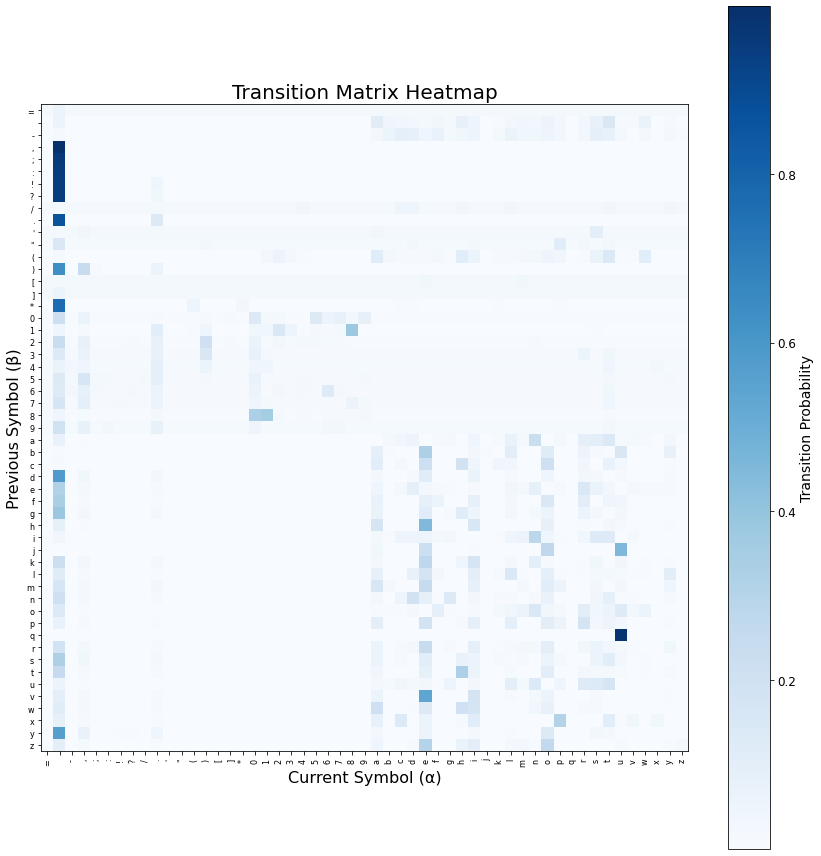

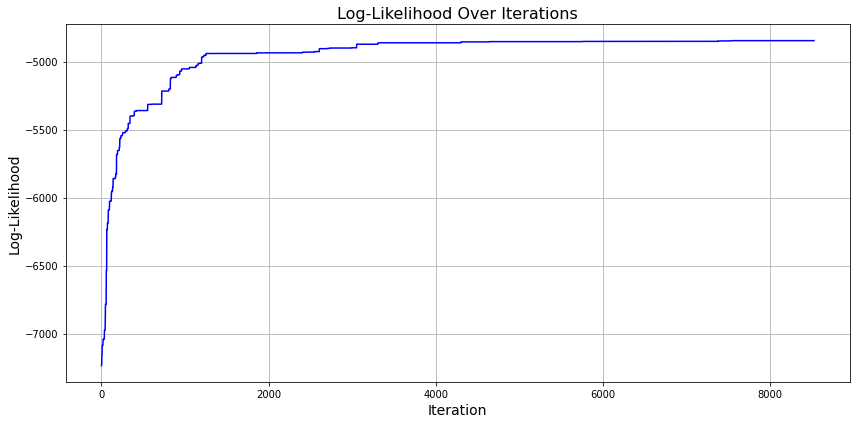

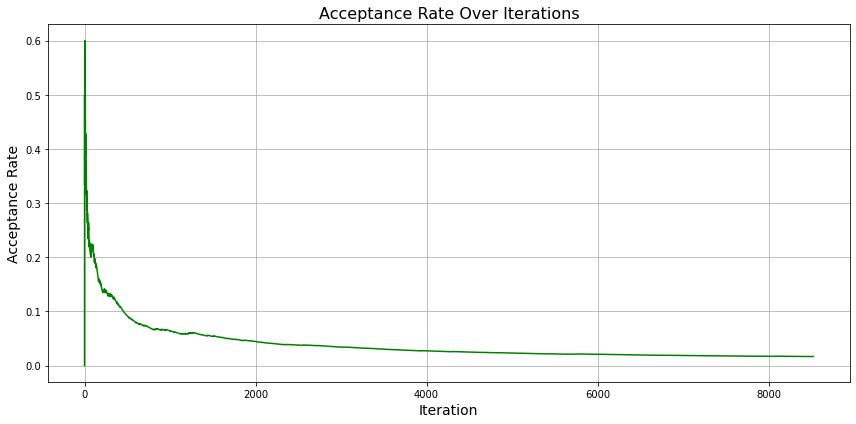

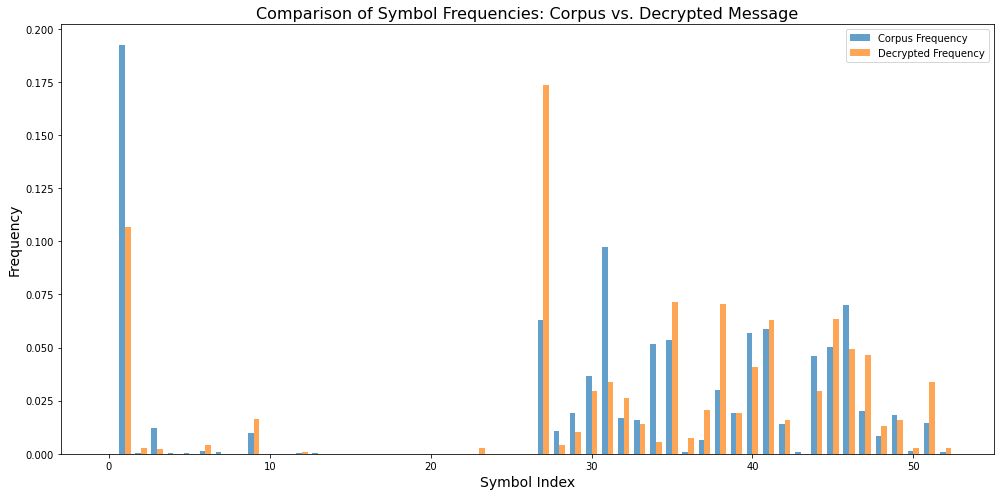

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import linear_sum_assignment

def load_symbols(symbols_file):
    """
    Load symbols from a file, replacing empty lines with a space character.

    Args:
        symbols_file (str): Path to the symbols file.

    Returns:
        list: A list of symbols.
    """
    with open(symbols_file, 'r') as f:
        symbols = [line.rstrip('\n') for line in f]
    # Replace empty strings with space character to represent '⟨space⟩'
    symbols = [symbol if symbol else ' ' for symbol in symbols]
    return symbols

# Load the list of symbols from 'symbols.txt'
symbols = load_symbols('symbols.txt')

# Create dictionaries to map symbols to indices and vice versa
symbol_to_index = {symbol: idx for idx, symbol in enumerate(symbols)}
index_to_symbol = {idx: symbol for idx, symbol in enumerate(symbols)}
N_symbols = len(symbols)  # Total number of unique symbols

# FOR DEBUGGING: Verify that the space character is present in the symbol mappings
if ' ' not in symbol_to_index:
    raise ValueError("Space character ' ' is not present in symbols.txt.")

# Load the encrypted message from 'message.txt'
with open('message.txt', 'r') as f:
    encrypted_message = f.read().strip()

# FOR DEBUGGING: Identify all unique symbols present in the encrypted message
unique_encrypted_symbols = set(encrypted_message)

# FOR DEBUGGING: Check for any symbols in the encrypted message that are not in 'symbols.txt'
missing_symbols = unique_encrypted_symbols - set(symbols)
if missing_symbols:
    raise ValueError(f"Missing symbols in symbols.txt: {missing_symbols}")

# FOR DEBUGGING: Convert the encrypted message symbols to their corresponding indices
encrypted_indices = np.array([symbol_to_index[s] for s in encrypted_message], dtype=np.int32)

def load_corpus(corpus_file):
    """
    Load and preprocess the corpus text by retaining only allowed symbols.

    Args:
        corpus_file (str): Path to the corpus file.

    Returns:
        np.ndarray: Array of symbol indices representing the corpus.
    """
    with open(corpus_file, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    allowed_chars = set(symbols)
    # Replace any character not in allowed_chars with a space
    text = ''.join([char if char in allowed_chars else ' ' for char in text])
    # Convert text to indices
    text_indices = np.array([symbol_to_index[char] for char in text], dtype=np.int32)
    return text_indices

# Load and preprocess the corpus
corpus_indices = load_corpus('war_and_peace.txt')

# Vectorized unigram counts
unigram_counts = np.bincount(corpus_indices, minlength=N_symbols)

# Vectorized bigram counts
indices1 = corpus_indices[:-1]
indices2 = corpus_indices[1:]
bigram_counts = np.zeros((N_symbols, N_symbols), dtype=np.int32)
np.add.at(bigram_counts, (indices1, indices2), 1)

# Apply Laplace (add-one) smoothing to unigram and bigram counts to avoid zero probabilities
unigram_counts += 1
bigram_counts += 1

# Compute unigram probabilities (stationary distribution) by normalizing unigram counts
phi = unigram_counts / np.sum(unigram_counts)

# Compute bigram probabilities (transition probabilities) by normalizing bigram counts
bigram_totals = bigram_counts.sum(axis=1, keepdims=True)  # Sum of bigrams starting with each symbol
psi = bigram_counts / bigram_totals

# Precompute logarithms
log_phi = np.log(phi)
log_psi = np.log(psi)

# Vectorized encrypted unigram counts
encrypted_unigram_counts = np.bincount(encrypted_indices, minlength=N_symbols)

# Vectorized encrypted bigram counts
encrypted_indices1 = encrypted_indices[:-1]
encrypted_indices2 = encrypted_indices[1:]
encrypted_bigram_counts = np.zeros((N_symbols, N_symbols), dtype=np.int32)
np.add.at(encrypted_bigram_counts, (encrypted_indices1, encrypted_indices2), 1)

# More Sophisticated Intelligent Initialization
# Step 1: Compute bigram probabilities for encrypted text
encrypted_bigram_probs = encrypted_bigram_counts / encrypted_bigram_counts.sum(axis=1, keepdims=True)

# Step 2: Compute bigram probabilities for the corpus
corpus_bigram_probs = bigram_counts / bigram_counts.sum(axis=1, keepdims=True)

# Replace any NaNs resulting from division by zero with zeros
encrypted_bigram_probs = np.nan_to_num(encrypted_bigram_probs)
corpus_bigram_probs = np.nan_to_num(corpus_bigram_probs)

# Step 3: Compute the cost matrix using Jensen-Shannon divergence
cost_matrix = np.zeros((N_symbols, N_symbols))

for i in range(N_symbols):
    p = encrypted_bigram_probs[i, :]
    for j in range(N_symbols):
        q = corpus_bigram_probs[j, :]
        # Compute Jensen-Shannon divergence
        m = 0.5 * (p + q)
        # Add a small epsilon to avoid log(0)
        epsilon = 1e-10
        p = p + epsilon
        q = q + epsilon
        m = m + epsilon
        cost_matrix[i, j] = 0.5 * (scipy.stats.entropy(p, m)) + 0.5 * (scipy.stats.entropy(q, m))

# Step 4: Solve the assignment problem to find the best initial permutation
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Initialize the permutation array where index corresponds to ciphertext symbol
# and value corresponds to plaintext symbol
initial_permutation = np.zeros(N_symbols, dtype=np.int32)
initial_permutation[row_ind] = col_ind

def compute_initial_log_likelihood(decrypted_indices, log_phi, log_psi):
    """
    Compute the initial log-likelihood of the decrypted message.

    Args:
        decrypted_indices (np.ndarray): Array of decrypted symbol indices.
        log_phi (np.ndarray): Logarithm of unigram probabilities.
        log_psi (np.ndarray): Logarithm of bigram probabilities.

    Returns:
        float: Log-likelihood value.
    """
    first_idx = decrypted_indices[0]
    log_likelihood = log_phi[first_idx]
    prev_indices = decrypted_indices[:-1]
    curr_indices = decrypted_indices[1:]
    log_likelihood += np.sum(log_psi[prev_indices, curr_indices])
    return log_likelihood

# Precompute decrypted indices
decrypted_indices = initial_permutation[encrypted_indices]

# Precompute initial log-likelihood
current_log_likelihood = compute_initial_log_likelihood(decrypted_indices, log_phi, log_psi)
best_permutation = initial_permutation.copy()
best_log_likelihood = current_log_likelihood

# Metropolis-Hastings sampler parameters
num_iterations = 10000    # Total number of MH iterations
print_interval = 100     # Interval at which to print decrypted text

# Lists to store log-likelihoods and acceptance rates for plotting
log_likelihood_history = []
acceptance_history = []

# Counter for accepted proposals to calculate acceptance rate
accepted = 0

# Run the Metropolis-Hastings sampler
for iteration in range(1, num_iterations + 1):
    # Propose a new permutation by swapping two randomly selected symbols
    i, j = np.random.choice(N_symbols, 2, replace=False)

    # Create a proposal permutation
    proposal_permutation = best_permutation.copy()
    proposal_permutation[i], proposal_permutation[j] = proposal_permutation[j], proposal_permutation[i]

    # Update decrypted indices only at positions where the swapped symbols occur
    affected_positions = np.where((encrypted_indices == i) | (encrypted_indices == j))[0]

    # If there are no affected positions, continue to next iteration
    if affected_positions.size == 0:
        continue

    # Compute the difference in log-likelihood
    delta_log_likelihood = 0.0

    # Positions to consider for delta computation (affected positions and their neighbors)
    positions = np.unique(np.concatenate([affected_positions - 1, affected_positions, affected_positions + 1]))
    positions = positions[(positions >= 0) & (positions < len(encrypted_indices))]

    # Current decrypted indices at these positions
    current_dec_indices = decrypted_indices[positions]

    # Proposed decrypted indices at these positions
    proposed_dec_indices = current_dec_indices.copy()
    mapping = {best_permutation[i]: proposal_permutation[i], best_permutation[j]: proposal_permutation[j]}
    for k in range(len(proposed_dec_indices)):
        idx = proposed_dec_indices[k]
        if idx in mapping:
            proposed_dec_indices[k] = mapping[idx]

    # Compute log-likelihood for current and proposed decrypted indices
    # For efficiency, we only compute the log-likelihood difference at the affected positions
    # Current log-likelihood
    current_ll = 0.0
    for pos in positions:
        idx = decrypted_indices[pos]
        if pos == 0:
            current_ll += log_phi[idx]
        else:
            idx_prev = decrypted_indices[pos - 1]
            current_ll += log_psi[idx_prev, idx]

    # Proposed log-likelihood
    proposed_ll = 0.0
    for idx, pos in zip(proposed_dec_indices, positions):
        if pos == 0:
            proposed_ll += log_phi[idx]
        else:
            idx_prev = proposed_dec_indices[np.where(positions == pos - 1)[0][0]] if pos - 1 in positions else decrypted_indices[pos - 1]
            proposed_ll += log_psi[idx_prev, idx]

    delta_log_likelihood = proposed_ll - current_ll

    # Compute acceptance probability using the Metropolis criterion
    acceptance_prob = min(1, np.exp(delta_log_likelihood))

    # Decide whether to accept the proposed permutation
    if np.random.rand() < acceptance_prob:
        # Accept the proposal
        best_permutation = proposal_permutation
        decrypted_indices[affected_positions] = proposed_dec_indices[np.isin(positions, affected_positions)]
        current_log_likelihood += delta_log_likelihood
        accepted += 1

        # Update the best permutation found if the new one has a higher log-likelihood
        if current_log_likelihood > best_log_likelihood:
            best_log_likelihood = current_log_likelihood

    # Record log-likelihood and acceptance status for plotting
    log_likelihood_history.append(best_log_likelihood)
    acceptance_history.append(accepted / iteration)  # Running acceptance rate

    # Print the decrypted text of the first 60 symbols at specified intervals
    if iteration % print_interval == 0:
        partial_decrypted_indices = best_permutation[encrypted_indices[:60]]  # Decrypt first 60 symbols
        decrypted_text = ''.join([index_to_symbol[idx] for idx in partial_decrypted_indices])
        print(f"Iteration {iteration}: {decrypted_text}")

# After sampling, compute the final acceptance rate
final_acceptance_rate = accepted / num_iterations
print(f"\nFinal Acceptance Rate: {final_acceptance_rate:.2f}")

# Output the final decrypted message using the best permutation found
full_decrypted_indices = best_permutation[encrypted_indices]
full_decrypted_text = ''.join([index_to_symbol[idx] for idx in full_decrypted_indices])

print("\nDecrypted Message:")
print(full_decrypted_text)

# Plotting the Transition Matrix Heatmap
plt.figure(figsize=(12, 12))
plt.imshow(psi, cmap='Blues', interpolation='nearest')
plt.title('Transition Matrix Heatmap', fontsize=20)
plt.xlabel('Current Symbol (α)', fontsize=16)
plt.ylabel('Previous Symbol (β)', fontsize=16)

# Set ticks to symbols with rotation for better readability
plt.xticks(ticks=np.arange(N_symbols), labels=symbols, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(N_symbols), labels=symbols, fontsize=8)

# Add colorbar with label
cbar = plt.colorbar()
cbar.set_label('Transition Probability', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('transition_matrix_heatmap.png', dpi=300)
plt.show()

# Plotting the Log-Likelihood Over Iterations
plt.figure(figsize=(12, 6))
plt.plot(log_likelihood_history, color='blue')
plt.title('Log-Likelihood Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log-Likelihood', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('log_likelihood_over_iterations.png', dpi=300)
plt.show()

# Plotting the Acceptance Rate Over Iterations
plt.figure(figsize=(12, 6))
plt.plot(acceptance_history, color='green')
plt.title('Acceptance Rate Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Acceptance Rate', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('acceptance_rate_over_iterations.png', dpi=300)
plt.show()

# Plotting Symbol Frequency Comparison
# Compute decrypted unigram counts
decrypted_unigram_counts = np.bincount(full_decrypted_indices, minlength=N_symbols)

# Normalize counts to get frequencies
decrypted_freq = decrypted_unigram_counts / decrypted_unigram_counts.sum()
corpus_freq = unigram_counts / unigram_counts.sum()

# Plotting comparison of frequencies
plt.figure(figsize=(14, 7))
indices = np.arange(N_symbols)
width = 0.35  # Width of the bars

plt.bar(indices - width/2, corpus_freq, width, label='Corpus Frequency', alpha=0.7)
plt.bar(indices + width/2, decrypted_freq, width, label='Decrypted Frequency', alpha=0.7)

plt.xlabel('Symbol Index', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Comparison of Symbol Frequencies: Corpus vs. Decrypted Message', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig('symbol_frequency_comparison.png', dpi=300)
plt.show()


Iteration 200: on ys saunlew rn. yawe cudnewrpde serwi ys grthew lrce ye ia
Iteration 300: on mw waunles rn. mase cudnesrpde wersi mw grthes lrce me ia
Iteration 400: on mw waunles rnv mase cudnesrpde wersi mw grthes lrce me ia
Iteration 500: on mw waunvei rnl maie cudneirpde weris mw grthei vrce me sa
Iteration 600: on mw waunkei rnl maie cudneirvde weris mw grthei krce me sa
Iteration 700: on mw waunkei rnl maie cuyneirvye weris mw grthei krce me sa
Iteration 800: on v. .aunkel rni vale cuynelrmye .erls v. grthel krce ve sa
Iteration 900: on v. .aunkel rni vale cuynelrmye .erls v. grthel krce ve sa
Iteration 1000: on v. .aunkel rni vale puynelrmye .erls v. grthel krpe ve sa
Iteration 1200: on i. .aungel rnv iale puynelrmye .erls i. krthel grpe ie sa
Iteration 1300: on i. .aungel rnv iale puynelrmye .erls i. krthel grpe ie sa
Iteration 1400: on p. .aungel rnv pale iuynelrmye .erls p. krthel grie pe sa
Iteration 1500: on p. .aungel rni pale vumnelryme .erls p. krthel grve pe sa
Iterati

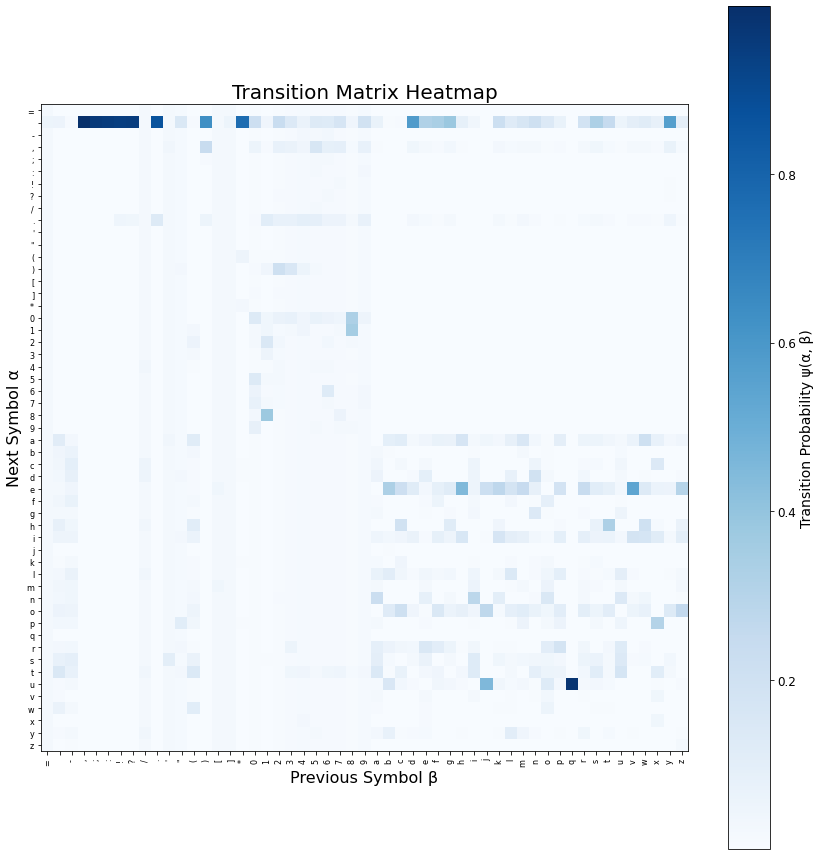

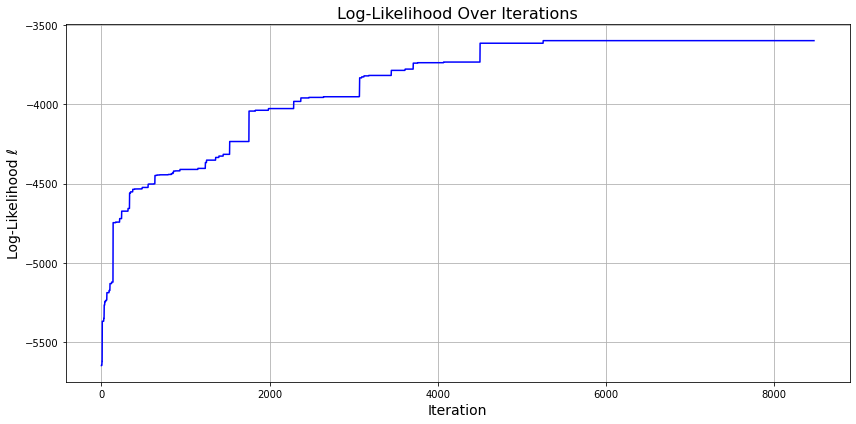

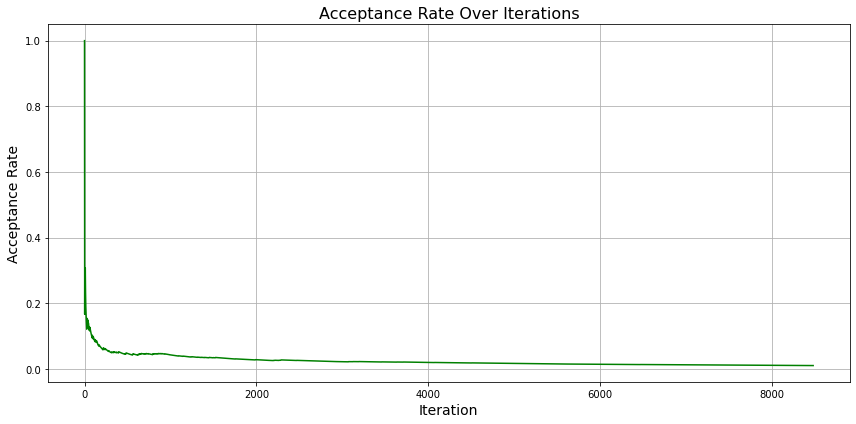

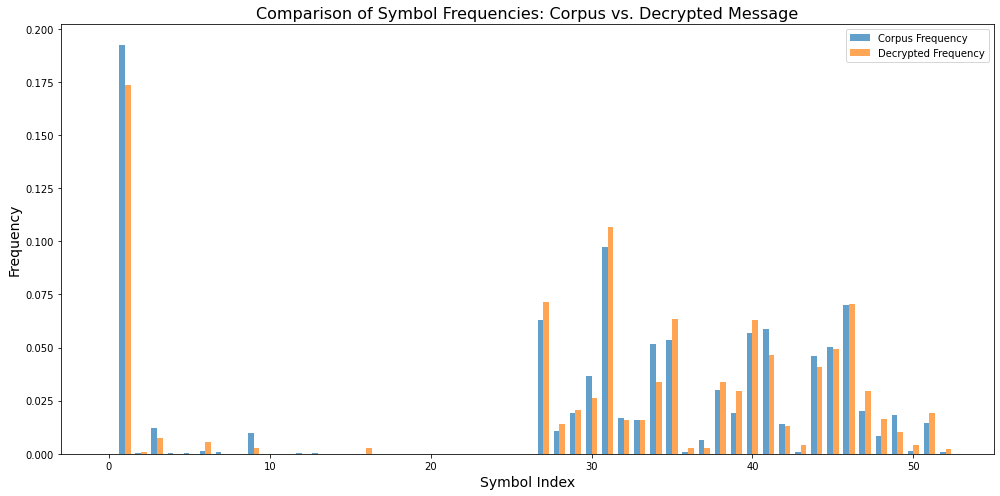

In [19]:
import numpy as np
import matplotlib.pyplot as plt


def load_symbols(symbols_file):
    """
    Load symbols from a file, replacing empty lines with a space character.

    Args:
        symbols_file (str): Path to the symbols file.

    Returns:
        list: A list of symbols.
    """
    with open(symbols_file, 'r') as f:
        symbols = [line.rstrip('\n') for line in f]
    # Replace empty strings with space character to represent '⟨space⟩'
    symbols = [symbol if symbol else ' ' for symbol in symbols]
    return symbols


# Load the list of symbols from 'symbols.txt'
symbols = load_symbols('symbols.txt')

# Create dictionaries to map symbols to indices and vice versa
symbol_to_index = {symbol: idx for idx, symbol in enumerate(symbols)}
index_to_symbol = {idx: symbol for idx, symbol in enumerate(symbols)}
K = len(symbols)  # Total number of unique symbols

# Verify that the space character is present in the symbol mappings
if ' ' not in symbol_to_index:
    raise ValueError("Space character ' ' is not present in symbols.txt.")

# Load the encrypted message from 'message.txt'
with open('message.txt', 'r') as f:
    encrypted_message = f.read().strip()

# Identify all unique symbols present in the encrypted message
unique_encrypted_symbols = set(encrypted_message)

# Check for any symbols in the encrypted message that are not in 'symbols.txt'
missing_symbols = unique_encrypted_symbols - set(symbols)
if missing_symbols:
    raise ValueError(f"Missing symbols in symbols.txt: {missing_symbols}")

# Convert the encrypted message symbols to their corresponding indices
encrypted_indices = np.array(
    [symbol_to_index[s] for s in encrypted_message], dtype=np.int32
)


def load_corpus(corpus_file):
    """
    Load and preprocess the corpus text by retaining only allowed symbols.

    Args:
        corpus_file (str): Path to the corpus file.

    Returns:
        np.ndarray: Array of symbol indices representing the corpus.
    """
    with open(corpus_file, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    allowed_chars = set(symbols)
    # Replace any character not in allowed_chars with a space
    text = ''.join([char if char in allowed_chars else ' ' for char in text])
    # Convert text to indices
    text_indices = np.array(
        [symbol_to_index[char] for char in text], dtype=np.int32
    )
    return text_indices


# Load and preprocess the corpus
corpus_indices = load_corpus('war_and_peace.txt')

# Estimate Unigram Counts C(γ)
# C(γ) is the count of symbol γ appearing in the corpus
C_gamma = np.bincount(corpus_indices, minlength=K)

# Estimate Bigram Counts N(α, β)
# N(α, β) is the count of times symbol β is followed by symbol α in the corpus
indices_prev = corpus_indices[:-1]
indices_next = corpus_indices[1:]
N_alpha_beta = np.zeros((K, K), dtype=np.int32)
np.add.at(N_alpha_beta, (indices_next, indices_prev), 1)

# Apply Laplace smoothing to counts to avoid zero probabilities
C_gamma += 1
N_alpha_beta += 1

# Compute Total Counts
# N is the total number of symbols (after smoothing)
N_total = np.sum(C_gamma)
C_beta = np.sum(N_alpha_beta, axis=0)  # Total count of symbol β in corpus (with smoothing)

# Estimate Unigram Probabilities φ(γ)
# φ(γ) = C'(γ) / N', where C'(γ) is the smoothed count
phi_gamma = C_gamma / N_total

# Estimate Bigram Probabilities ψ(α, β)
# ψ(α, β) = N'(α, β) / C'(β), where N'(α, β) is the smoothed count
psi_alpha_beta = N_alpha_beta / C_beta[np.newaxis, :]

# Precompute logarithms for numerical stability
log_phi_gamma = np.log(phi_gamma)
log_psi_alpha_beta = np.log(psi_alpha_beta)

# Encrypted message counts
# Unigram counts in encrypted message
C_encrypted_gamma = np.bincount(
    encrypted_indices, minlength=K
)

# Bigram counts in encrypted message
indices_encrypted_prev = encrypted_indices[:-1]
indices_encrypted_next = encrypted_indices[1:]
N_encrypted_alpha_beta = np.zeros((K, K), dtype=np.int32)
np.add.at(
    N_encrypted_alpha_beta, (indices_encrypted_next, indices_encrypted_prev), 1
)

# Initial Permutation based on Unigram Frequencies
# Sort plaintext symbols by descending counts
plaintext_indices_sorted = np.argsort(-C_gamma)
# Sort ciphertext symbols by descending counts in the encrypted message
ciphertext_indices_sorted = np.argsort(-C_encrypted_gamma)

# Initialize the permutation array π where index corresponds to ciphertext symbol
# and value corresponds to plaintext symbol
pi = np.zeros(K, dtype=np.int32)
pi[ciphertext_indices_sorted] = plaintext_indices_sorted


def refine_permutation(pi, plaintext_bigram_freq, ciphertext_bigram_freq, iterations=5):
    """
    Refine permutation π by swapping symbol mappings to better align bigram frequencies.

    Args:
        pi (np.ndarray): Current permutation array mapping ciphertext to plaintext indices.
        plaintext_bigram_freq (np.ndarray): Normalized bigram frequencies from the corpus.
        ciphertext_bigram_freq (np.ndarray): Normalized bigram frequencies from the encrypted message.
        iterations (int): Number of refinement iterations to perform.

    Returns:
        np.ndarray: Refined permutation array.
    """
    for _ in range(iterations):
        # Iterate over each ciphertext symbol
        for i in range(K):
            # Get the current plaintext symbol mapped to this ciphertext symbol
            pi_i = pi[i]
            # Compute current score based on absolute difference in bigram frequencies
            current_score = np.sum(
                np.abs(ciphertext_bigram_freq[i] - plaintext_bigram_freq[pi_i])
            )
            # Try swapping with other ciphertext symbols
            for j in range(K):
                if j == i:
                    continue
                pi_j = pi[j]
                # Swap the mappings
                pi[i], pi[j] = pi_j, pi_i
                # Compute new score after swapping
                new_score = (
                    np.sum(
                        np.abs(ciphertext_bigram_freq[i] - plaintext_bigram_freq[pi_j])
                    )
                    + np.sum(
                        np.abs(ciphertext_bigram_freq[j] - plaintext_bigram_freq[pi_i])
                    )
                )
                # If the new score is better, keep the swap
                if new_score < current_score:
                    current_score = new_score
                    pi_i = pi_j
                else:
                    # Revert the swap
                    pi[i], pi[j] = pi_i, pi_j
    return pi


# Normalize bigram counts to frequencies for comparison
plaintext_bigram_freq = N_alpha_beta / N_alpha_beta.sum()
ciphertext_bigram_freq = N_encrypted_alpha_beta / N_encrypted_alpha_beta.sum()

# Refine the initial permutation to better align bigram frequencies
pi = refine_permutation(
    pi,
    plaintext_bigram_freq,
    ciphertext_bigram_freq,
    iterations=3,
)

# Precompute decrypted indices based on current permutation
decrypted_indices = pi[encrypted_indices]


def compute_log_likelihood(decrypted_indices, log_phi_gamma, log_psi_alpha_beta):
    """
    Compute the log-likelihood of the decrypted message.

    The log-likelihood is calculated based on the unigram and bigram probabilities
    from the corpus. It represents how probable the decrypted message is under
    the language model defined by φ and ψ.

    Args:
        decrypted_indices (np.ndarray): Array of decrypted symbol indices.
        log_phi_gamma (np.ndarray): Logarithm of unigram probabilities φ(γ).
        log_psi_alpha_beta (np.ndarray): Logarithm of bigram probabilities ψ(α, β).

    Returns:
        float: Log-likelihood value.
    """
    first_idx = decrypted_indices[0]
    log_likelihood = log_phi_gamma[first_idx]  # Log probability of the first symbol
    prev_indices = decrypted_indices[:-1]
    curr_indices = decrypted_indices[1:]
    # Sum the log probabilities of each bigram in the decrypted message
    log_likelihood += np.sum(log_psi_alpha_beta[curr_indices, prev_indices])
    return log_likelihood


# Compute the initial log-likelihood
current_log_likelihood = compute_log_likelihood(
    decrypted_indices, log_phi_gamma, log_psi_alpha_beta
)
best_pi = pi.copy()
best_log_likelihood = current_log_likelihood

# Metropolis-Hastings sampler parameters
num_iterations = 10000    # Total number of iterations
print_interval = 100      # Interval at which to print decrypted text

# Lists to store log-likelihoods and acceptance rates for plotting
log_likelihood_history = []
acceptance_history = []

# Counter for accepted proposals to calculate acceptance rate
accepted = 0

# Run the Metropolis-Hastings sampler
for iteration in range(1, num_iterations + 1):
    # Propose a new permutation by swapping two randomly selected symbols
    i, j = np.random.choice(K, 2, replace=False)

    # Create a proposal permutation π'
    pi_proposal = pi.copy()
    pi_proposal[i], pi_proposal[j] = pi_proposal[j], pi_proposal[i]

    # Update decrypted indices only at positions where the swapped symbols occur
    affected_positions = np.where(
        (encrypted_indices == i) | (encrypted_indices == j)
    )[0]

    # If there are no affected positions, continue to next iteration
    if affected_positions.size == 0:
        continue

    # Compute the difference in log-likelihood Δℓ
    delta_log_likelihood = 0.0

    # Positions to consider for delta computation (affected positions and neighbors)
    positions = np.unique(
        np.concatenate(
            [affected_positions - 1, affected_positions, affected_positions + 1]
        )
    )
    positions = positions[
        (positions >= 0) & (positions < len(encrypted_indices))
    ]

    # Current decrypted indices at these positions
    current_dec_indices = decrypted_indices[positions]

    # Proposed decrypted indices at these positions
    proposed_dec_indices = current_dec_indices.copy()
    # Mapping of plaintext symbols after the proposed swap
    mapping = {
        pi[i]: pi_proposal[i],
        pi[j]: pi_proposal[j]
    }
    for k in range(len(proposed_dec_indices)):
        idx = proposed_dec_indices[k]
        if idx in mapping:
            proposed_dec_indices[k] = mapping[idx]

    # Compute log-likelihood for current and proposed decrypted indices
    # Current log-likelihood ℓ_current
    current_ll = 0.0
    for pos in positions:
        idx = decrypted_indices[pos]
        if pos == 0:
            current_ll += log_phi_gamma[idx]
        else:
            idx_prev = decrypted_indices[pos - 1]
            current_ll += log_psi_alpha_beta[idx, idx_prev]

    # Proposed log-likelihood ℓ_proposed
    proposed_ll = 0.0
    for pos in positions:
        idx = proposed_dec_indices[np.where(positions == pos)[0][0]]
        if pos == 0:
            proposed_ll += log_phi_gamma[idx]
        else:
            if pos - 1 in positions:
                idx_prev = proposed_dec_indices[np.where(positions == pos - 1)[0][0]]
            else:
                idx_prev = decrypted_indices[pos - 1]
            proposed_ll += log_psi_alpha_beta[idx, idx_prev]

    # Calculate the change in log-likelihood Δℓ
    delta_log_likelihood = proposed_ll - current_ll

    # Compute acceptance probability using the Metropolis criterion
    acceptance_prob = min(1, np.exp(delta_log_likelihood))

    # Decide whether to accept the proposed permutation
    if np.random.rand() < acceptance_prob:
        # Accept the proposal
        pi = pi_proposal
        decrypted_indices[affected_positions] = proposed_dec_indices[
            np.isin(positions, affected_positions)
        ]
        current_log_likelihood += delta_log_likelihood
        accepted += 1

        # Update the best permutation found if the new one has a higher log-likelihood
        if current_log_likelihood > best_log_likelihood:
            best_pi = pi.copy()
            best_log_likelihood = current_log_likelihood

    # Record log-likelihood and acceptance status for plotting
    log_likelihood_history.append(best_log_likelihood)
    acceptance_history.append(accepted / iteration)  # Running acceptance rate

    # Print the decrypted text of the first 60 symbols at specified intervals
    if iteration % print_interval == 0:
        partial_decrypted_indices = best_pi[encrypted_indices[:60]]
        decrypted_text = ''.join(
            [index_to_symbol[idx] for idx in partial_decrypted_indices]
        )
        print(f"Iteration {iteration}: {decrypted_text}")

# After sampling, compute the final acceptance rate
final_acceptance_rate = accepted / num_iterations
print(f"\nFinal Acceptance Rate: {final_acceptance_rate:.2f}")

# Output the final decrypted message using the best permutation found
full_decrypted_indices = best_pi[encrypted_indices]
full_decrypted_text = ''.join(
    [index_to_symbol[idx] for idx in full_decrypted_indices]
)

print("\nDecrypted Message:")
print(full_decrypted_text)

# Plotting the Transition Matrix Heatmap
plt.figure(figsize=(12, 12))
plt.imshow(psi_alpha_beta, cmap='Blues', interpolation='nearest')
plt.title('Transition Matrix Heatmap', fontsize=20)
plt.xlabel('Previous Symbol β', fontsize=16)
plt.ylabel('Next Symbol α', fontsize=16)

# Set ticks to symbols with rotation for better readability
plt.xticks(ticks=np.arange(K), labels=symbols, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(K), labels=symbols, fontsize=8)

# Add colorbar with label
cbar = plt.colorbar()
cbar.set_label('Transition Probability ψ(α, β)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('transition_matrix_heatmap.png', dpi=300)
plt.show()

# Plotting the Log-Likelihood Over Iterations
plt.figure(figsize=(12, 6))
plt.plot(log_likelihood_history, color='blue')
plt.title('Log-Likelihood Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log-Likelihood ℓ', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('log_likelihood_over_iterations.png', dpi=300)
plt.show()

# Plotting the Acceptance Rate Over Iterations
plt.figure(figsize=(12, 6))
plt.plot(acceptance_history, color='green')
plt.title('Acceptance Rate Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Acceptance Rate', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('acceptance_rate_over_iterations.png', dpi=300)
plt.show()

# Plotting Symbol Frequency Comparison
# Compute decrypted unigram counts
C_decrypted_gamma = np.bincount(full_decrypted_indices, minlength=K)

# Normalize counts to get frequencies
freq_decrypted = C_decrypted_gamma / C_decrypted_gamma.sum()
freq_corpus = C_gamma / C_gamma.sum()

# Plotting comparison of frequencies
plt.figure(figsize=(14, 7))
indices = np.arange(K)
width = 0.35  # Width of the bars

plt.bar(
    indices - width / 2, freq_corpus, width, label='Corpus Frequency', alpha=0.7
)
plt.bar(
    indices + width / 2, freq_decrypted, width, label='Decrypted Frequency', alpha=0.7
)

plt.xlabel('Symbol Index', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(
    'Comparison of Symbol Frequencies: Corpus vs. Decrypted Message',
    fontsize=16,
)
plt.legend()
plt.tight_layout()
plt.savefig('symbol_frequency_comparison.png', dpi=300)
plt.show()
